In [1]:
from bootstrap_stat import bootstrap_stat as bp
from IPython.display import display
from mlxtend.evaluate import bias_variance_decomp

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

df = pd.read_csv('../data/test_pred.csv')
display(df.columns)

np.random.seed(42)

Index(['title', 'total_game_hours_last_two_weeks', 'num_groups', 'orig_url',
       'num_badges', 'review_url', 'num_found_funny', 'review', 'date_updated',
       'num_workshop_items', 'date_posted', 'found_helpful_percentage',
       'num_voted_helpfulness', 'achievement_progress', 'profile_url',
       'num_found_helpful', 'steam_id_number', 'friend_player_level',
       'num_found_unhelpful', 'total_game_hours', 'username', 'num_guides',
       'rating', 'num_friends', 'num_screenshots', 'num_comments',
       'num_reviews', 'num_games_owned', 'pred_rfr_untuned',
       'pred_xgbr_untuned', 'pred_krr_untuned', 'pred_linr_untuned',
       'pred_lstm_untuned', 'pred_lstm2_untuned'],
      dtype='object')

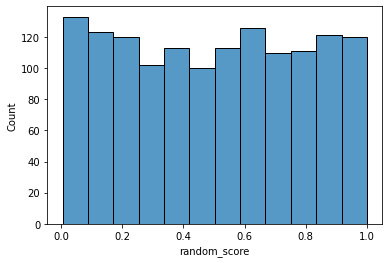

In [2]:
df['random_score'] = np.random.uniform(low=0, high=1, size=len(df))
df['random_diff'] = df.random_score - df.found_helpful_percentage
sns.histplot(data=df, x='random_score');

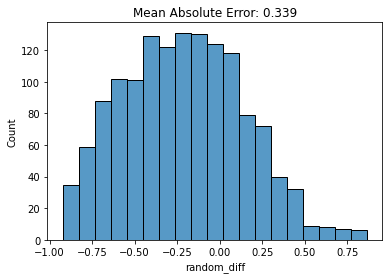

In [3]:
ax = sns.histplot(x=df['random_diff'])
ax.set_title('Mean Absolute Error: {:.3f}'.format(np.abs(df.random_diff).mean()));

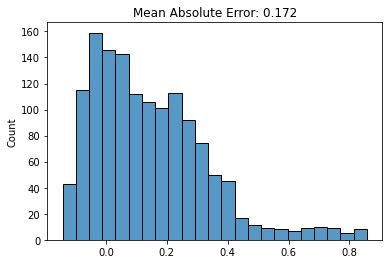

In [4]:
# use the most probable value as the regressed value

values = df.found_helpful_percentage
kernel = stats.gaussian_kde(values)
height = kernel.pdf(values)
mode_value = values[np.argmax(height)]
df['mpv'] = mode_value
ax2 = sns.histplot(x=df.mpv-df.found_helpful_percentage)
ax2.set_title('Mean Absolute Error: {:.3f}'.format(np.abs(df.mpv-df.found_helpful_percentage).mean()));

# Evaluate Models by Bias-Variance Decomposition

In [5]:
import pickle as pkl
import xgboost

# load data
glove_dim = 300
train_fpn = '../data/train_glove{}d.pkl'.format(glove_dim)
test_fpn = '../data/test_glove{}d.pkl'.format(glove_dim)
with open(train_fpn, 'rb') as f:
    X_train, y_train = pkl.load(f)
with open(test_fpn, 'rb') as f:
    X_test, y_test = pkl.load(f)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
# make the customized regression models
from sklearn.base import BaseEstimator, RegressorMixin
class RandomGuessRegressor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.random.uniform(low=0, high=1, size=len(X))

# estimate bias and variance
mse, bias, var = bias_variance_decomp(RandomGuessRegressor(), X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.165
Bias: 0.082
Variance: 0.083


In [32]:
# use bootstrap method to estimate bias
dist = bp.EmpiricalDistribution(pd.DataFrame(X_test))

def random_guess(X):
    return np.random.uniform(low=0, high=1)

def my_t(X):
    idx = np.where(np.all(X_test==X, axis=1))
    return y_test[idx]
bias = bp.bias(dist, random_guess, my_t, B=1000)
stderr = bp.standard_error(dist, random_guess, B=1000)
print(bias)
print(stderr)
print((bias**2+stderr**2).mean())

[-0.22912897 -0.45185625 -0.32944245 ... -0.00185625 -0.25595461
 -0.37167873]
0.28701758771252606
0.16526286961833214


In [19]:
class MostFrequentRegressor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.values = y
        return self
    def predict(self, X):
        # kernel = stats.gaussian_kde(self.values)
        # height = kernel.pdf(self.values)
        # mode_value = self.values[np.argmax(height)]
        # return mode_value
        return self.values.mean()

# estimate bias and variance
mse, bias, var = bias_variance_decomp(MostFrequentRegressor(), X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.036
Bias: 0.036
Variance: 0.000


[-0.01261938 -0.23534665 -0.11293286 ...  0.21465335 -0.03944501
 -0.15516913]
2.221557105636704e-16
0.03600736835520112


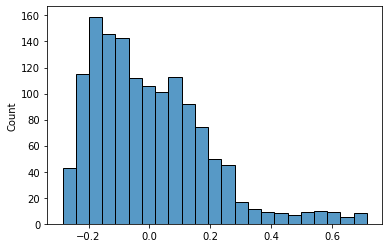

In [37]:
def always_mean(X):
    return y_test.mean()

bias = bp.bias(dist, always_mean, my_t, B=1000)
stderr = bp.standard_error(dist, always_mean, B=1000)
print(bias)
print(stderr)
print((bias**2+stderr**2).mean())
sns.histplot(x=bias);

In [42]:
# define the models
model = xgboost.XGBRegressor(n_estimators=500, max_depth=3, colsample_bytree=0.7, learning_rate=0.01, min_child_weight=1, subsample=0.7)
model.fit(pd.DataFrame(X_train), y_train)
# # estimate bias and variance
# mse, bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)
# # summarize results
# print('MSE: %.3f' % mse)
# print('Bias: %.3f' % bias)
# print('Variance: %.3f' % var)

XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, n_estimators=500,
             subsample=0.7)

In [45]:
def xgbr(X):
    idx = np.where(np.all(X_test==X, axis=1))
    return model.predict(X[idx])

bias = bp.bias(dist, xgbr, my_t, B=1000)
stderr = bp.standard_error(dist, xgbr, B=1000)
print(bias)
print(stderr)
print((bias**2+stderr**2).mean())

KeyError: (array([], dtype=int64),)